____
__Universite de Technologie de Troyes__<br/>
__Universidad Tecnologica Nacional Buenos Aires__<br/>
__Master OSS__<br/>
__Machine Learning & Pattern Recognition__<br/>
__Practice Sessions__<br/>
__Teacher: Martin Palazzo__
____

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_boston
from sklearn.datasets import load_diabetes
from sklearn import datasets
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
sns.set_context("talk", font_scale=0.85)

# **Define useful functions**

In [2]:
# define gaussian kernel
def gaussian_kernel(X, Y, sigma):
    """
    computes Gram matrix K using a Gaussian kernel
    K_ij = exp(-||X[:,i]-Y[:,j]||^2/(2*sigma^2))
    
    arguments:
    X     --  nxd array
    Y     --  nxd array
    sigma --  kernel width
    
    returns:
    K     --  nxn Gram matrix     
    """
    
    if X.shape[1] != Y.shape[1] :
        raise(ValueError('X and Y must have the same dimensions'))
    
    nx, d = X.shape
    ny    = Y.shape[0]
    
    G = (X**2).sum(axis=1) 
    H = (Y**2).sum(axis=1)
    
    Q = np.tile(G[:,np.newaxis],(1,ny))
    R = np.tile(H, (nx,1))
    
    K = Q + R -2*np.dot(X, Y.T)
    
    K = np.exp(-K/(2*sigma**2))
    
    return K

In [3]:
# Center kernel matrix

def center_kernel(K):
  N = K.shape[0]
  one_n = np.ones((N,N)) / N
  K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)    
  return K

In [4]:
# Spiral synthetic dataset generator

def make_spiral(n_samples, tot_feats, frac_noise_feats, frac_informative_feats, plot = False):
    # make spiral generator function adapted by Martin Palazzo
    # original function from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5

    from numpy import pi
    
    N = n_samples
    theta = (np.sqrt(np.random.rand(N))*2*pi) # np.linspace(0,2*pi,100)

    r_a = 2*theta + pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + np.random.randn(N,2)

    r_b = -2*theta - pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + np.random.randn(N,2)

    res_a = np.append(x_a, np.zeros((N,1)), axis=1)
    res_b = np.append(x_b, np.ones((N,1)), axis=1)

    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)

    if plot == True:
      plt.scatter(x_a[:,0],x_a[:,1], alpha = 0.5, s = 40, c = 'r')
      plt.scatter(x_b[:,0],x_b[:,1], alpha = 0.5, s = 40, c = 'b')
      plt.show()


    x_gt = np.concatenate((x_a, x_b))

    x_re1 = np.concatenate((x_a+0.1, x_b+0.1))
    x_re2 = np.concatenate((x_a+0.1, x_b+0.1))

    #x0 = np.concatenate((np.concatenate((x_gt, x_re1), axis = 1),x_re2), axis = 1)
    x0 = np.dot(x_gt, np.random.normal(0,0.6,size=(2,int(frac_informative_feats*tot_feats))))
    x_noise = np.random.normal(0,5,size=(N*2,int(frac_noise_feats*tot_feats)))

    y = pd.DataFrame(np.concatenate((np.full((N,1),0),np.full((N,1),1))))

    x = pd.DataFrame(np.concatenate((x_noise, x0), axis = 1))
    
    return x,y

In [5]:
# XOR dataset
def make_xor(n_samples, feats_informative, feats_noise, noise, separability=1, var=0.2,plot = False):

  sep = separability
  n=n_samples
  #x1 = np.random.rand(n,2) * (-1)
  x1 = np.random.normal(-sep,var,(n,2))
  #x2 = np.random.rand(n,2)
  x2 = np.random.normal(sep,var,(n,2))
  x2[:,1] *= (-1)

  #x3 = np.random.rand(n,2)
  x3 = np.random.normal(sep,var,(n,2))
  x3[:,0] *= (-1)
  #x4 = np.random.rand(n,2)
  x4 = np.random.normal(sep,var,(n,2))
  x0 = np.concatenate((x1, x2, x3, x4))
  x0 = (x0 + 1 ) /2
  x_signal = np.dot(x0,np.subtract(np.random.rand(2,feats_informative),0.5))
  x_noise = np.subtract(np.random.rand(n*4,feats_noise),0.5)*noise
  #print(np.shape(x_noise))
  #print(np.shape(x0))
  x = np.concatenate((x_noise,x_signal), axis =1)
  y1 = np.ones(n)
  y4 = np.ones(n)
  y2 = np.full(n,0)
  y3 = np.full(n,0)
  y = np.concatenate((y1,y2,y3,y4))
  #print (x1[[1,2],:])
  #print (x2[[1,2],:])
  #print (x3[[1,2],:])
  #print (x4[[1,2],:])


#  plt.scatter(x_a[:,0],x_a[:,1], alpha = 0.5, s = 40)
  if plot == True:
    plt.scatter(x1[:,0], x1[:,1], c= 'r', alpha = 0.5, s = 30)
    plt.scatter(x2[:,0], x2[:,1], c = 'b', alpha = 0.5, s = 30)
    plt.scatter(x3[:,0], x3[:,1], c = 'b', alpha = 0.5, s = 30)
    plt.scatter(x4[:,0], x4[:,1], c = 'r', alpha = 0.5, s = 30)
    plt.show()

  return x, y

In [6]:
# visualization of the obtained latent space
def visualize_latent_pca(x, y):
  from sklearn.decomposition import PCA
  pca = PCA(n_components = 2)
  zpca = pca.fit_transform(x)
  plt.scatter(zpca[y == 0,0], zpca[y == 0,1], alpha = 0.5, s = 30)
  plt.scatter(zpca[y == 1,0], zpca[y == 1,1], alpha = 0.5, s = 30)
  plt.show()

# Create datasets and train-test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# make spiral dataset
# 1000 samples per class
# 100 features in total
# 50% informative features
# 50% noise features
x_sp0 , y_sp0 = make_spiral(1000, 100, 0.5, 0.5)

In [9]:
# make XOR dataset
# make spiral dataset
# 1000 samples per class
# 100 informative features
# 100 noise features
x_xor0 , y_xor0 = make_xor(1000, 100, 100, 2, separability = 1, var = 0.4)

In [34]:
# train test split of Spiral data
x_sp, x_sp_te, y_sp, y_sp_te = train_test_split(pd.DataFrame(x_sp0), pd.DataFrame(y_sp0), test_size=0.3, random_state=42)

In [42]:
y_sp = y_sp.sort_values(0)
x_sp = x_sp.reindex(y_sp.index)

In [43]:
# train test split of Spiral data
x_xor, x_xor_te, y_xor, y_xor_te = train_test_split(x_xor0, y_xor0, test_size=0.3, random_state=42)

In [44]:
x_sp.shape

(1400, 100)

In [45]:
x_sp_te.shape

(600, 100)

Visualize the X matrix

Text(0.5, 1.0, 'X matrix Spiral data')

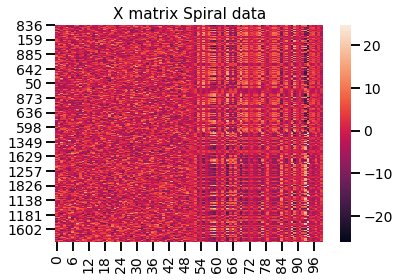

In [46]:
sns.heatmap(x_sp)
plt.title('X matrix Spiral data')

Text(0.5, 1.0, 'X matrix XOR data')

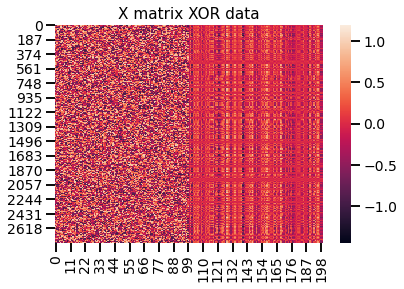

In [47]:
sns.heatmap(x_xor)
plt.title('X matrix XOR data')

# **Principal Component Analysis: spiral dataset case**

Covariance matrix
$$
\Sigma = \frac{1}{n-1}((X - \bar{x}^{T})(X - \bar{x}))
$$

In [48]:
# create co-variance matrix 
cov_sp = np.cov(np.transpose(x_sp))

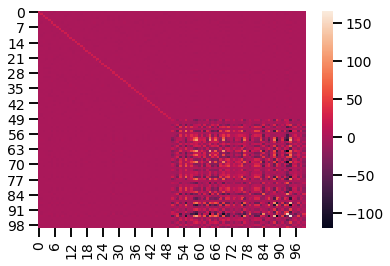

In [49]:
# visualize covariance matrix
sns.heatmap(cov_sp)
plt.plot('Covariance Matrix')

Perform eigen decomposition

$$
\Sigma = \upsilon \lambda \upsilon^{-1} \rightarrow \beta_{dp} \rightarrow X .\beta = z
$$

In [50]:
from numpy import linalg as LA

In [51]:
# perform eigen-decomposition on the covariance matrix
eig_vals_sp , eig_vecs_sp = LA.eig(cov_sp)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


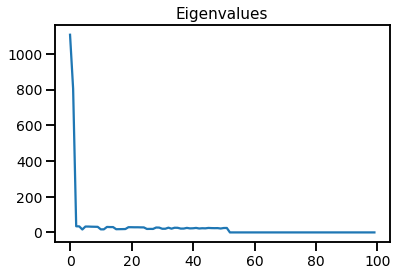

In [52]:
#plot the eigenvalues
plt.plot(eig_vals_sp)
plt.title('Eigenvalues')
plt.show()

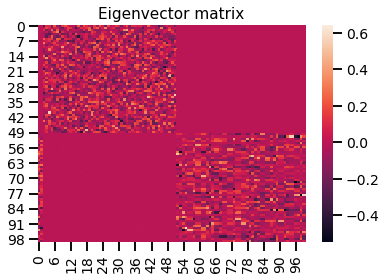

In [53]:
#visualize the eigen-vectors matrix
sns.heatmap(eig_vecs_sp.real)
plt.title('Eigenvector matrix')
plt.show()

In [54]:
eig_vecs_sp.real.shape

(100, 100)

In [55]:
# define the latent dimensions
latent_dim = 10

In [56]:
# obtain the beta matrix, the one used to project the input data into the latent space such as z = np.dot(x, beta)
# the number of eigenvectors retained is equal to the size of the latent dimension
beta_pca_sp = eig_vecs_sp.real[:,:latent_dim]

In [57]:
beta_pca_sp.shape

(100, 10)

In [58]:
# project the input data x into the latent space z via the beta matrix
z_pca_sp = np.dot(x_sp,beta_pca_sp)

In [59]:
z_pca_sp.shape

(1400, 10)

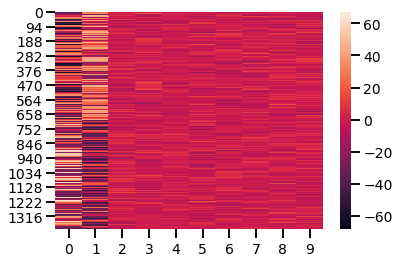

In [77]:
# visualize the latent space z matrix
sns.heatmap(z_pca_sp)

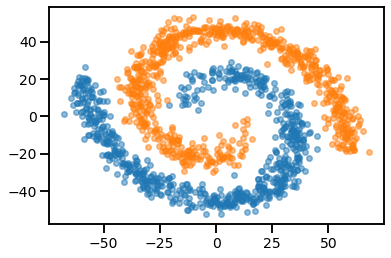

In [60]:
# visualize the latent space obtained with PCA of 2 components
visualize_latent_pca(z_pca_sp,y_sp.values.ravel())

# **Kernels**

Compute the kernel matrices

$$
G(x_1, x_2,x_3,...., x_n) = \begin{vmatrix}
\left \langle x_1 , x_1 \right \rangle & \left \langle x_1 , x_2 \right \rangle & ... & \left \langle x_1 , x_n \right \rangle\\ 
\left \langle x_2 , x_1 \right \rangle & ... & ... & ...\\ 
... & ... & ... &... \\ 
\left \langle x_n , x_1 \right \rangle & ... & ... & \left \langle x_n , x_n \right \rangle
\end{vmatrix}
$$

Linear Kernel
$$
k(x,x^{'}) = \langle x,x^{'}\rangle
$$

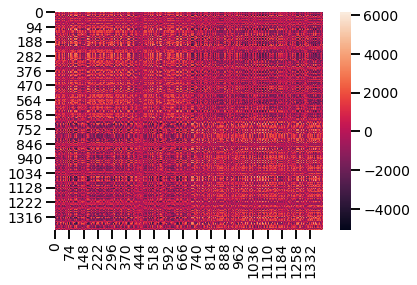

In [61]:
# Create a Linear Kernel 
kernel_lin_sp = center_kernel(np.dot(x_sp, np.transpose(x_sp)))
sns.heatmap(kernel_lin_sp)

Gaussian Kernel
$$
k_g(x_i, x_j) = \text{exp}\left ( \frac{\left \| x_i-x_j \right \|^{2}}{2\sigma ^{2}} \right )
$$

In [65]:
sigma = 35

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


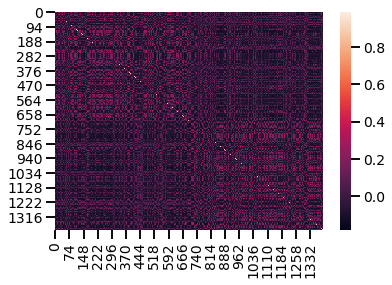

In [66]:
# create gaussian kernel matrix
kernel_gau_sp = center_kernel(gaussian_kernel(x_sp,x_sp, sigma))
sns.heatmap(kernel_gau_sp)

# **Kernel PCA: Gaussian kernel**

Compute the eigen decomposition of the kernel matrix


$$
K = n U^{-1} \Lambda U \rightarrow Z_{np} = KU^{*}
$$

In [67]:
# eigen decomposition of the kernel matrix
eig_vals_kpca_sp , eig_vecs_kpca_sp = LA.eig(kernel_gau_sp)

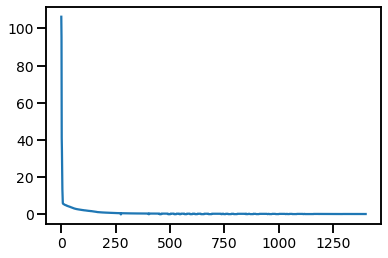

In [68]:
# plot eigen values
plt.plot(eig_vals_kpca_sp)

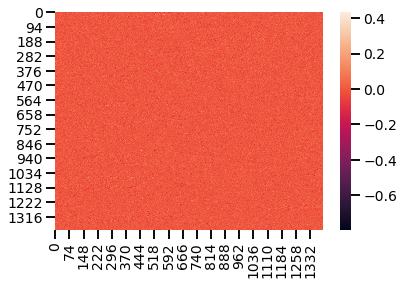

In [69]:
# plot eigen vectors matrix
sns.heatmap(eig_vecs_kpca_sp.real)

In [70]:
# obtain the beta matrix for data projection into the latent space
beta_kpca = eig_vecs_kpca_sp.real[:,:latent_dim]

In [71]:
# project the samples in the latent space
z_kpca_sp = np.dot(kernel_gau_sp.real,beta_kpca)

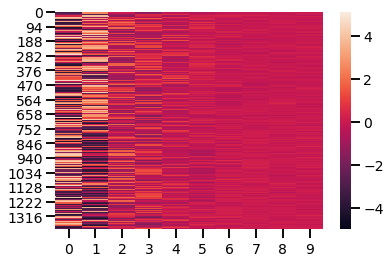

In [76]:
# visualize the latent space z matrix
sns.heatmap(z_kpca_sp)

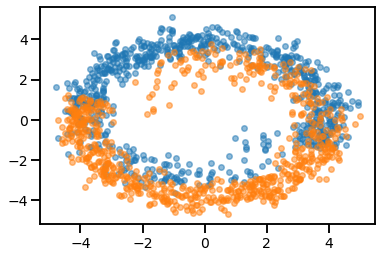

In [72]:
# visualize the kpca latent space
visualize_latent_pca(z_kpca_sp, y_sp.values.ravel())

# **Random Projections**

In [78]:
# create the beta matrix composed by random values
beta_random = np.random.rand(x_sp.shape[1],latent_dim)

In [79]:
# project the input training data into the latent space via beta matrix
z_random_proj_sp = np.dot(x_sp, beta_random)

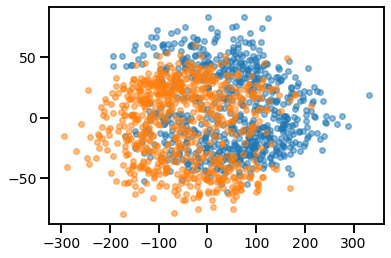

In [80]:
# visualize 
visualize_latent_pca(z_random_proj_sp, y_sp.values.ravel())

# **Classification using the latent space**
- train a SVM model with Linear Kernel in the three obtained latent spaces for latent dimensions l = [2,4,6,8,10]
- train a SVM model with Gaussian kernel in the three obtained latent spaces for latent dimensions l = [2,4,6,8,10]

In [81]:
from sklearn.svm import SVC
# documentation -> https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [84]:
# compute the z_pca_sp_te matrix
# compute the z_kpca_sp_te matrix
# compute the z_rand_sp_te matrix

In [82]:
# define one model per latent space
svc_lin_pca = SVC(C = 1, kernel='linear')
svc_lin_kpca = SVC(C = 1, kernel='linear')
svc_lin_rand = SVC(C = 1, kernel='linear')

In [83]:
# define one model per latent space
svc_rbf_pca = SVC(C = 1, kernel='rbf', gamma = 1)
svc_rbf_kpca = SVC(C = 1, kernel='rbf', gamma = 1)
svc_rbf_rand = SVC(C = 1, kernel='rbf', gamma = 1)

In [85]:
from sklearn.metrics import accuracy_score
# train model
# svc_lin_pca.fit(z_pca_sp, y_sp)
# evaluate model
# ypred_klin_pca = svc_lin_pca.predict(z_pca_sp_te)
# accuracy_score(y_sp_te,y_pred_klin_pca)

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion_matrix(y_sp_te,y_pred_klin_pca)